# **Scouting Analysis:**

**Problem Statement:**

Who is the best pinch hitter inside the PP in the ipl so far? 

**Criteria** : Min 20 Innings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.expand_frame_repr',False)
pd.set_option('max.colwidth',-1)



In [3]:
from google.colab import files
uploaded = files.upload()

Saving deliveries.csv to deliveries.csv
Saving matches.csv to matches.csv


In [4]:
matches = pd.read_csv('matches.csv')
deliveries = pd.read_csv('deliveries.csv')


In [5]:
df = deliveries.copy()
mf = matches.copy()

In [6]:
df['one'] = df['batsman_runs'].apply(lambda x:  1 if x==1 else 0 )
df['two'] = df['batsman_runs'].apply(lambda x: 1 if x==2 else 0 )
df['three'] = df['batsman_runs'].apply(lambda x: 1 if x==3 else 0 )
df['four'] = df['batsman_runs'].apply(lambda x:  1 if x==4 else 0 )
df['six'] = df['batsman_runs'].apply(lambda x: 1 if x==6 else 0 )
df['dot'] = df['batsman_runs'].apply(lambda x: 1 if x==0 else 0 )


In [7]:
def phase(over):
  if over < 6:
    return 'Powerplay'
  elif over < 15:
    return 'Middle'
  else:
    return 'Death'


In [8]:
df['Phase'] = df['over'].apply(lambda x : phase(x))

Extracting Player Details for Given Phase:

In [9]:
def Custom(df,current_phase):
  df = df[df.Phase == current_phase]
  df.reset_index(inplace = True,drop = True)

  runs = pd.DataFrame(df.groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'Runs'}))
  balls = pd.DataFrame(df.groupby(['batsman'])['batsman_runs'].count().reset_index().rename(columns={'batsman_runs':'Balls_Faced'}))
  dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count().reset_index().rename(columns={'player_dismissed':'Dismissals'}))
  innings = pd.DataFrame(df.groupby(['batsman'])['matchId'].apply(lambda x : len(list(np.unique(x)))).reset_index().rename(columns={'matchId':'Innings'}))

  ones = pd.DataFrame(df.groupby(['batsman'])['one'].sum().reset_index().rename(columns={'one':'Ones'}))
  twos = pd.DataFrame(df.groupby(['batsman'])['two'].sum().reset_index().rename(columns={'two':'Twos'}))
  three = pd.DataFrame(df.groupby(['batsman'])['three'].sum().reset_index().rename(columns={'three':'Threes'}))
  fours = pd.DataFrame(df.groupby(['batsman'])['four'].sum().reset_index().rename(columns={'four':'Fours'}))
  sixes = pd.DataFrame(df.groupby(['batsman'])['six'].sum().reset_index().rename(columns={'six':'Sixes'}))
  dots = pd.DataFrame(df.groupby(['batsman'])['dot'].sum().reset_index().rename(columns={'dot':'Dots'}))

  df = pd.merge(runs,balls,on='batsman').merge(dismissals,on='batsman').merge(innings,on='batsman').merge(ones,on='batsman').merge(twos,on='batsman').merge(three,on='batsman').merge(fours,on='batsman').merge(sixes,on='batsman').merge(dots,on='batsman')
  
  
  return df

In [10]:
df1 = Custom(df,'Powerplay')
df2 = Custom(df,'Middle')
df3 = Custom(df,'Death')


***Criteria for Scouting Analysis : Min - 20 Innings***

In [11]:
df1 = df1[df1.Innings > 20]

In [12]:
df1['RPI'] = df1.apply(lambda x : x['Runs']/x['Innings'],axis=1)

In [13]:
df1['Boundaries'] = df1['Fours'] + df1['Sixes'] 

In [14]:
def BPB(Balls,Boundary):
  if Boundary > 0 :
    return Balls / Boundary 
  else:
    return Balls

def BPD(Balls,Dismissals):
  if Dismissals > 0:
    return Balls / Dismissals
  else:
    return Balls

def Average(Runs,Dismissals):
  if Dismissals > 0:
    return Runs/Dismissals
  else:
    return Runs

In [15]:
df1['BPB'] = df1.apply(lambda x : BPB(x['Balls_Faced'],x['Boundaries']),axis=1)
df1['BPD'] = df1.apply(lambda x : BPB(x['Balls_Faced'],x['Dismissals']),axis=1)
df1['Average'] = df1.apply(lambda x : BPB(x['Runs'],x['Dismissals']),axis=1)
df1['StrikeRate'] = df1.apply(lambda x : (x['Runs'] / x['Balls_Faced'])*100,axis=1)
df1['DotPercentage'] = df1.apply(lambda x: (x['Dots']/x['Balls_Faced'])*100,axis=1)

In [17]:
df1.head(5)

,batsman,Runs,Balls_Faced,Dismissals,Innings,Ones,Twos,Threes,Fours,Sixes,Dots,RPI,Boundaries,BPB,BPD,Average,StrikeRate,DotPercentage
14,AB de Villiers,741,630,22,81,164,24,3,100,20,319,9.148148,120,5.250000,28.636364,33.681818,117.619048,50.634921
16,AC Gilchrist,1385,1080,48,80,244,37,3,191,49,556,17.312500,240,4.500000,22.500000,28.854167,128.240741,51.481481
24,AJ Finch,911,826,40,71,194,39,3,120,25,445,12.830986,145,5.696552,20.650000,22.775000,110.290557,53.874092
28,AM Rahane,2049,1837,66,139,550,76,11,273,37,890,14.741007,310,5.925806,27.833333,31.045455,111.540555,48.448557
34,AT Rayudu,777,750,23,82,215,23,0,93,24,395,9.475610,117,6.410256,32.608696,33.782609,103.600000,52.666667


***Pair Wise Comparison to determine criteria weights:***

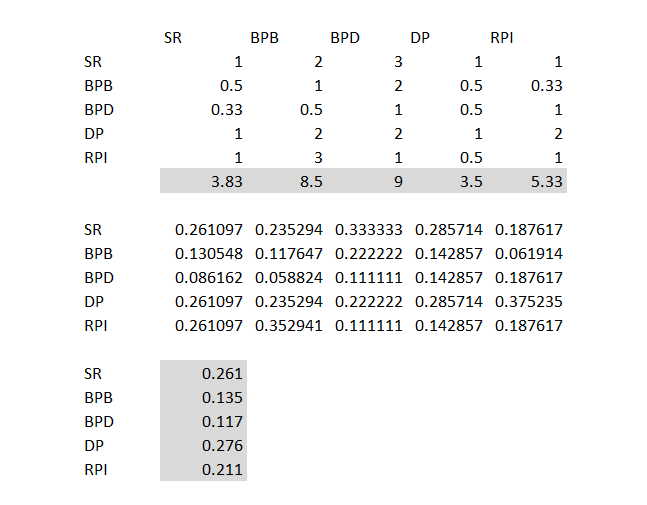

In [18]:
wt_SR,wt_BPB,wt_BPD,wt_DP,wt_RPI = 0.261,0.135,0.117,0.276,0.211

**Calculating the score using MinMax Value:**

In [19]:
min_val = min(df1['StrikeRate']) 
max_val = max(df1['StrikeRate'])

df1['mx_SR'] = df1['StrikeRate'].apply(lambda x: (x - min_val)/(max_val - min_val))

In [20]:
min_val = max(df1['BPB']) 
max_val = min(df1['BPB'])

df1['mx_BPB'] = df1['BPB'].apply(lambda x: (x - min_val)/(max_val - min_val))

In [21]:
min_val = min(df1['BPD'])
max_val = max(df1['BPD'])

df1['mx_BPD'] = df1['BPD'].apply(lambda x : (x - min_val)/(max_val - min_val))

In [22]:
min_val = max(df1['DotPercentage'])
max_val = min(df1['DotPercentage'])

df1['mx_DP'] = df1['DotPercentage'].apply(lambda x : (x - min_val)/(max_val - min_val))

In [23]:
min_val = min(df1['RPI'])
max_val = max(df1['RPI'])

df1['mx_RPI'] = df1['RPI'].apply(lambda x : (x - min_val)/(max_val - min_val))

In [25]:
df1['minmax_score'] = df1.apply(lambda x : (x['mx_SR']*0.261 + x['mx_BPB']*0.135 + x['mx_BPD']*0.117 + x['mx_DP']*0.276 + x['mx_RPI']*0.211),axis=1)

In [26]:
df1[['batsman','Runs','Balls_Faced','Innings','StrikeRate','DotPercentage','BPB','BPD','minmax_score']].sort_values(by='minmax_score',ascending=False).head(5).reset_index()

,index,batsman,Runs,Balls_Faced,Innings,StrikeRate,DotPercentage,BPB,BPD,minmax_score
0,214,PP Shaw,1129,787,63,143.456163,43.837357,4.142105,20.179487,0.785652
1,121,JM Bairstow,695,487,36,142.710472,47.433265,4.127119,30.437500,0.784824
2,115,JC Buttler,1230,882,62,139.455782,49.206349,4.160377,33.923077,0.769205
3,58,CA Lynn,779,553,40,140.867993,49.005425,4.066176,32.529412,0.769136
4,140,KP Pietersen,392,301,28,130.232558,44.518272,5.101695,60.200000,0.754015


**Calculating the score using Standardisation method:**

In [27]:
mean_val = np.mean(df1['StrikeRate'])
std_val = np.std(df1['StrikeRate'])

df1['st_SR'] = df1['StrikeRate'].apply(lambda x : (x - mean_val)/(std_val))

In [28]:
mean_val = np.mean(df1['BPB'])
std_val = np.std(df1['BPB'])

df1['st_BPB'] = df1['BPB'].apply(lambda x : (x - mean_val)/(std_val))

In [29]:
mean_val = np.mean(df1['BPD'])
std_val = np.std(df1['BPD'])

df1['st_BPD'] = df1['BPD'].apply(lambda x : (x - mean_val)/(std_val))

In [30]:
mean_val = np.mean(df1['DotPercentage'])
std_val = np.std(df1['DotPercentage'])

df1['st_DP'] = df1['DotPercentage'].apply(lambda x : (x - mean_val)/(std_val))

In [31]:
mean_val = np.mean(df1['RPI'])
std_val = np.std(df1['RPI'])

df1['st_RPI'] = df1['RPI'].apply(lambda x : (x - mean_val)/(std_val))

In [32]:
df1['st_score'] = df1.apply(lambda x : (x['st_SR']*0.261 + x['st_BPB']*0.135 + x['st_BPD']*0.117 + x['st_DP']*0.276 + x['st_RPI']*0.211), axis=1)

In [34]:
df1.sort_values(by='st_score',ascending=False).head(5).reset_index()

,index,batsman,Runs,Balls_Faced,Dismissals,Innings,Ones,Twos,Threes,Fours,Sixes,Dots,RPI,Boundaries,BPB,BPD,Average,StrikeRate,DotPercentage,mx_SR,mx_BPB,mx_BPD,mx_DP,mx_RPI,minmax_score,st_SR,st_BPB,st_BPD,st_DP,st_RPI,st_score
0,87,DR Smith,1213,1003,27,65,217,44,2,155,47,538,18.661538,202,4.965347,37.148148,44.925926,120.937188,53.639083,0.508891,0.687128,0.524069,0.550738,0.915858,0.632148,0.282914,-0.563149,0.949030,0.435906,1.477602,0.540936
1,60,CH Gayle,2405,1851,66,135,379,41,2,267,145,1017,17.814815,412,4.492718,28.045455,36.439394,129.929768,54.943274,0.606354,0.772134,0.336134,0.491934,0.855335,0.618074,0.860902,-1.048602,-0.098171,0.722015,1.241000,0.532775
2,278,ST Jayasuriya,514,403,20,30,64,12,5,61,27,233,17.133333,88,4.579545,20.150000,25.700000,127.543424,57.816377,0.580490,0.756518,0.173124,0.362390,0.806624,0.544111,0.707522,-0.959419,-1.006488,1.352308,1.050571,0.532290
3,150,LMP Simmons,542,480,12,29,116,22,0,67,19,256,18.689655,86,5.581395,40.000000,45.166667,112.916667,53.333333,0.421963,0.576326,0.582949,0.564524,0.917867,0.605620,-0.232595,0.069616,1.277116,0.368831,1.485459,0.513343
4,115,JC Buttler,1230,882,26,62,204,30,1,157,55,434,19.838710,212,4.160377,33.923077,47.307692,139.455782,49.206349,0.709599,0.831909,0.457484,0.750604,1.000000,0.769205,1.473175,-1.389961,0.578008,-0.536535,1.806543,0.497578


**Calculating the score using the Topsis Method:**

In [35]:
df1['calc_SR'] = df1['StrikeRate'].apply(lambda x: x*x)
df1['calc_BPB'] = df1['BPB'].apply(lambda x: x*x)
df1['calc_BPD'] = df1['BPD'].apply(lambda x: x*x)
df1['calc_DP'] = df1['DotPercentage'].apply(lambda x: x*x)
df1['calc_RPI'] = df1['RPI'].apply(lambda x: x*x)



In [36]:
sq_SR,sq_BPB,sq_BPD,sq_DP,sq_RPI = np.sqrt(df1[['calc_SR','calc_BPB','calc_BPD','calc_DP','calc_RPI']].sum(axis=0))

In [37]:
df1['calc_SR'] = df1['StrikeRate'].apply(lambda x: x/sq_SR)
df1['calc_BPB'] = df1['BPB'].apply(lambda x: x/sq_BPB)
df1['calc_BPD'] = df1['BPD'].apply(lambda x: x/sq_BPD)
df1['calc_DP'] = df1['DotPercentage'].apply(lambda x: x/sq_DP)
df1['calc_RPI'] = df1['RPI'].apply(lambda x: x/sq_RPI)



In [38]:
df1['calc_SR'] = df1['StrikeRate'].apply(lambda x: x*wt_SR)
df1['calc_BPB'] = df1['BPB'].apply(lambda x: x*wt_BPB)
df1['calc_BPD'] = df1['BPD'].apply(lambda x: x*wt_BPD)
df1['calc_DP'] = df1['DotPercentage'].apply(lambda x: x*wt_DP)
df1['calc_RPI'] = df1['RPI'].apply(lambda x: x*wt_RPI)

best_SR, Worst_SR = max(df1['calc_SR']) , min(df1['calc_SR'])
best_BPB, Worst_BPB = min(df1['calc_BPB']) , max(df1['calc_BPB'])
best_BPD, Worst_BPD = max(df1['calc_BPD']) , min(df1['calc_BPD'])
best_DP, Worst_DP = min(df1['calc_DP']) , max(df1['calc_DP'])
best_RPI, Worst_RPI = max(df1['calc_RPI']) , min(df1['calc_RPI'])



**Comparing against the best and worst values:**

In [39]:
df1['d_best_SR'] = df1['calc_SR'].apply(lambda x : (x-best_SR)*(x-best_SR))
df1['d_best_BPB'] = df1['calc_BPB'].apply(lambda x : (x-best_BPB)*(x-best_BPB))
df1['d_best_BPD'] = df1['calc_BPD'].apply(lambda x : (x-best_BPD)*(x-best_BPD))
df1['d_best_DP'] = df1['calc_DP'].apply(lambda x : (x-best_DP)*(x-best_DP))
df1['d_best_RPI'] = df1['calc_RPI'].apply(lambda x : (x-best_RPI)*(x-best_RPI))

df1['d_best_score'] = df1.apply(lambda x : (x['d_best_SR'] + x['d_best_BPB'] + x['d_best_BPD'] + x['d_best_DP'] + x['d_best_RPI']),axis=1)




In [40]:
df1['d_worst_SR'] = df1['calc_SR'].apply(lambda x : (x-Worst_SR)*(x-Worst_SR))
df1['d_worst_BPB'] = df1['calc_BPB'].apply(lambda x : (x-Worst_BPB)*(x-Worst_BPB))
df1['d_worst_BPD'] = df1['calc_BPD'].apply(lambda x : (x-Worst_BPD)*(x-Worst_BPD))
df1['d_worst_DP'] = df1['calc_DP'].apply(lambda x : (x-Worst_DP)*(x-Worst_DP))
df1['d_worst_RPI'] = df1['calc_RPI'].apply(lambda x : (x-Worst_RPI)*(x-Worst_RPI))

df1['d_worst_score'] = df1.apply(lambda x : (x['d_worst_SR'] + x['d_worst_BPB'] + x['d_worst_BPD'] + x['d_worst_DP'] + x['d_worst_RPI']),axis=1)




In [41]:
df1['score'] = df1.apply(lambda x: x['d_worst_score']/(x['d_worst_score'] + x['d_best_score']),axis=1)

In [42]:
df1[['batsman','StrikeRate','RPI','BPB','BPD','DotPercentage','score']].sort_values(by='score',ascending=False).head(5)


,batsman,StrikeRate,RPI,BPB,BPD,DotPercentage,score
271,SP Narine,166.250000,15.833333,3.225806,11.764706,50.000000,0.943939
121,JM Bairstow,142.710472,19.305556,4.127119,30.437500,47.433265,0.876217
214,PP Shaw,143.456163,17.920635,4.142105,20.179487,43.837357,0.866609
58,CA Lynn,140.867993,19.475000,4.066176,32.529412,49.005425,0.857730
115,JC Buttler,139.455782,19.838710,4.160377,33.923077,49.206349,0.844206


## ***Conclusion:***

I tried to check the score using different normalisation methods and I will go with the result based on Topsis method as I feel this gives the result that is more relevant

According to the method, these are the top 5 players that teams should look for when it comes to bidding for Pinch hitter role in Auctions.

1) Sunil Narine

2) Johnny Bairstow

3) Prithvi Shaw

4) Chris Lynn

5) Jos Butler 

